In [1]:
import os
import path_file
os.chdir(os.path.dirname(os.path.dirname(path_file.__file__)))
os.getcwd()

'd:\\user\\Desktop\\Faculdade\\IC Rodolfo\\gasification 08-2023\\gasification'

In [2]:
import sys
import cantera as ct
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

import phases
import feedstock as fs
import fuel as fu
import energy as en
import gasifier as gs

For species Fe(c), discontinuity in cp/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  0.0
	Value computed using high-temperature polynomial: 4.2881898

For species Fe(c), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  0.0
	Value computed using high-temperature polynomial: 3.425820683333331

For species Fe(c), discontinuity in s/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  0.0
	Value computed using high-temperature polynomial: 8.486560101557188

For species Cr(cr), discontinuity in cp/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  749.1520512400002
	Value computed using high-temperature polynomial: 0.0

For species Cr(cr), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  113.24055562733336
	Value computed using high-temperature polynomial: 0.0

For species Cr(cr), discontinuity in s/R detec

In [3]:
ultimate = [46.76, 5.76, 45.83, 0.22, 0.67, 0] # %m/m, dry basis
moistWB = 0.1245 # fraction, wet basis
ashWB = 0.0077 # fraction, wet basis
GCV_WB = 17.36 # MJ/kg

GCV = GCV_WB / (1 - moistWB)
moistDB = moistWB / (1 - moistWB)
ashDB = ashWB / (1 - moistWB)

print(GCV)

conv = (phases.Pn) * (phases.Mw_air) / (phases.R * phases.Tn)

19.828669331810396


In [4]:
feedRate = np.array([1.73, 2.15, 2.64, 3.19, 3.69, 4.02, 4.06, 4.48, 4.70, 4.93, 5.40]) # kg/h of wet fuel
airRatio = np.array([1.63, 1.64, 1.52, 1.38, 1.51, 1.46, 1.47, 1.44, 1.37, 1.48, 1.50]) # Nm³/kg
dryFeedRate = (1 - moistWB) * feedRate # kg/h of dry fuel
airFlow = conv * airRatio * feedRate # kg/h of air

In [5]:
H2_exp = np.array([14.77, 14.62, 14.77, 14.77, 14.12, 13.13, 12.67, 11.86, 13.83, 11.33, 11.11])
N2_exp = np.array([58.67, 59.67, 56.96, 57.05, 57.07, 53.33, 54.71, 53.95, 54.24, 55.65, 55.83])
CH4_exp = np.array([1.40, 2.10, 1.94, 2.03, 1.70, 2.18, 1.97, 2.47, 1.98, 2.36, 2.15])
CO_exp = np.array([8.56, 8.92, 12.08, 14.41, 16.80, 20.66, 19.63, 19.89, 18.41, 18.99, 18.56])
CO2_exp = np.array([16.33, 13.92, 13.02, 11.42, 9.93, 9.52, 10.02, 11.25, 11.12, 11.09, 11.22])
gasFlow_exp = np.array([3.55, 4.44, 5.33, 6.22, 7.26, 8.15, 8.15, 9.18, 9.48, 10.07, 10.96]) # Nm³/h
HHV_exp = np.array([3.47, 3.76, 4.22, 4.50, 4.55, 5.12, 4.96, 5.15, 4.75, 4.86, 4.66]) # MJ/Nm³
gasYield_exp = gasFlow_exp / feedRate
print(gasYield_exp)
CGE_exp = gasYield_exp * HHV_exp / GCV_WB
print(CGE_exp)

[2.05202312 2.06511628 2.01893939 1.94984326 1.96747967 2.02736318
 2.00738916 2.04910714 2.01702128 2.04259635 2.02962963]
[0.41016822 0.44728325 0.49077905 0.50543172 0.51567008 0.597932
 0.57353976 0.60788605 0.55189234 0.57183285 0.54481994]


In [6]:
fuels = []
airs = []
ERs = np.zeros_like(feedRate)
outlets = []

for i, dryFeed in enumerate(dryFeedRate):
    fuel = fs.create_fuel_stream(dryFeed, ultimate, ashDB, moistDB, GCV)
    fuels.append(fuel)
    air = fs.create_air_stream(airFlow[i])
    airs.append(air)
    outlet = gs.gasify_nonisot(fuel, air, heatLossFraction=0.0)
    outlets.append(outlet)
    stoichAir = fs.create_air_from_ER(fuel, 1.0)
    ER = air.get_mass() / stoichAir.get_mass()
    ERs[i] = ER

In [7]:
syngasHHV = np.array([out.get_syngas_hhv(basis='vol', water=False, nitrogen=True) for out in outlets])
syngasFlow = np.array([out.get_syngas_amount(basis='vol', water=False, nitrogen=True) for out in outlets])
syngasYield = syngasFlow / feedRate
syngasCGE = np.array([out.get_syngas_CGE() for out in outlets])
temperatures = np.array([out.T for out in outlets]) # K
H2 = np.array([100*out.get_syngas_fraction(species='H2', water=False, nitrogen=True) for out in outlets])
N2 = np.array([100*out.get_syngas_fraction(species='N2', water=False, nitrogen=True) for out in outlets])
CH4 = np.array([100*out.get_syngas_fraction(species='CH4', water=False, nitrogen=True) for out in outlets])
CO = np.array([100*out.get_syngas_fraction(species='CO', water=False, nitrogen=True) for out in outlets])
CO2 = np.array([100*out.get_syngas_fraction(species='CO2', water=False, nitrogen=True) for out in outlets])
print(temperatures-273.15)

[1374.20336423 1380.11962734 1306.24946401 1211.64807557 1299.80276268
 1266.86839833 1273.54995177 1253.36053031 1204.51785081 1280.18378437
 1293.30982005]


In [8]:
# char_params = np.array([-111.1574, 3.9705, 0.0362, -7.1958, 3.0419, 1.2430, 0.1276, 1.1034, 1.4281])
# methane_params = np.array([16.5264, 0.4982, -0.0304, 0.1739, 0.2148, -0.1864, -0.1186, -0.2192, -0.2552])

# def char(ER, MC, T, C, H, O, ash):
#     a = lambda i: char_params[i]
#     return np.exp(a(0) + a(1)*ER + a(2)*MC + a(3)*((10**(-3))*T) + a(4)*((10**(-3))*T)**2 + a(5)*C + a(6)*H + a(7)*O +a(8)*ash)

# def met(ER, MC, T, C, H, O, ash):
#     b = lambda i: methane_params[i]
#     return np.exp(b(0) + b(1)*ER + b(2)*MC + b(3)*((10**(-3))*T) + b(4)*((10**(-3))*T)**2 + b(5)*C + b(6)*H + b(7)*O +b(8)*ash)

In [9]:
outlets_char = []
for i, fuel in enumerate(fuels):
    air = airs[i]
    ER = ERs[i]
    T = temperatures[i]
    # charFormation = char(ER, 100*moistDB, T, ultimate[0], ultimate[1], ultimate[2], 100*ashDB)
    # charFormation = 1 - (0.25 + 0.75*np.exp(-ER/0.23))
    # charFormation = 0.0647*ER*T**0.3 + 0.465
    # charFormation = 0.05
    # methaneConversion = met(ER, 100*moistDB, T, ultimate[0], ultimate[1], ultimate[2], 100*ashDB)
    # print(charFormation, methaneConversion)
    outlet = gs.gasify_nonisot(fuel, air, charFormation=0.05, directMethaneConv=0, heatLossFraction=0.0)
    outlets_char.append(outlet)

syngasHHV_char = np.array([out.get_syngas_hhv(basis='vol', water=False, nitrogen=True) for out in outlets_char])
syngasFlow_char = np.array([out.get_syngas_amount(basis='vol', water=False, nitrogen=True) for out in outlets_char])
syngasYield_char = syngasFlow_char / feedRate
syngasCGE_char = np.array([out.get_syngas_CGE() for out in outlets_char])
temperatures_char = np.array([out.T for out in outlets_char]) # K
H2_char = np.array([100*out.get_syngas_fraction(species='H2', water=False, nitrogen=True) for out in outlets_char])
N2_char = np.array([100*out.get_syngas_fraction(species='N2', water=False, nitrogen=True) for out in outlets_char])
CH4_char = np.array([100*out.get_syngas_fraction(species='CH4', water=False, nitrogen=True) for out in outlets_char])
CO_char = np.array([100*out.get_syngas_fraction(species='CO', water=False, nitrogen=True) for out in outlets_char])
CO2_char = np.array([100*out.get_syngas_fraction(species='CO2', water=False, nitrogen=True) for out in outlets_char])

In [10]:
outlets_met = []
for i, fuel in enumerate(fuels):
    air = airs[i]
    ER = ERs[i]
    T = temperatures[i]
    # charFormation = char(ER, 100*moistDB, T, ultimate[0], ultimate[1], ultimate[2], 100*ashDB)
    # methaneConversion = met(ER, 100*moistDB, T, ultimate[0], ultimate[1], ultimate[2], 100*ashDB)
    # print(charFormation, methaneConversion)
    outlet = gs.gasify_nonisot(fuel, air, charFormation=0, directMethaneConv=0.05, heatLossFraction=0.0)
    outlets_met.append(outlet)

syngasHHV_met = np.array([out.get_syngas_hhv(basis='vol', water=False, nitrogen=True) for out in outlets_met])
syngasFlow_met = np.array([out.get_syngas_amount(basis='vol', water=False, nitrogen=True) for out in outlets_met])
syngasYield_met = syngasFlow_met / feedRate
syngasCGE_met = np.array([out.get_syngas_CGE() for out in outlets_met])
temperatures_met = np.array([out.T for out in outlets_met]) # K
H2_met = np.array([100*out.get_syngas_fraction(species='H2', water=False, nitrogen=True) for out in outlets_met])
N2_met = np.array([100*out.get_syngas_fraction(species='N2', water=False, nitrogen=True) for out in outlets_met])
CH4_met = np.array([100*out.get_syngas_fraction(species='CH4', water=False, nitrogen=True) for out in outlets_met])
CO_met = np.array([100*out.get_syngas_fraction(species='CO', water=False, nitrogen=True) for out in outlets_met])
CO2_met = np.array([100*out.get_syngas_fraction(species='CO2', water=False, nitrogen=True) for out in outlets_met])

In [11]:
outlets_both = []
for i, fuel in enumerate(fuels):
    air = airs[i]
    ER = ERs[i]
    T = temperatures[i]
    # charFormation = char(ER, 100*moistDB, T, ultimate[0], ultimate[1], ultimate[2], 100*ashDB)
    # methaneConversion = met(ER, 100*moistDB, T, ultimate[0], ultimate[1], ultimate[2], 100*ashDB)
    # print(charFormation, methaneConversion)
    outlet = gs.gasify_nonisot(fuel, air, charFormation=0.05, directMethaneConv=0.05, heatLossFraction=0.0)
    outlets_both.append(outlet)

syngasHHV_both = np.array([out.get_syngas_hhv(basis='vol', water=False, nitrogen=True) for out in outlets_both])
syngasFlow_both = np.array([out.get_syngas_amount(basis='vol', water=False, nitrogen=True) for out in outlets_both])
syngasYield_both = syngasFlow_both / feedRate
syngasCGE_both = np.array([out.get_syngas_CGE() for out in outlets_both])
temperatures_both = np.array([out.T for out in outlets_both]) # K
H2_both = np.array([100*out.get_syngas_fraction(species='H2', water=False, nitrogen=True) for out in outlets_both])
N2_both = np.array([100*out.get_syngas_fraction(species='N2', water=False, nitrogen=True) for out in outlets_both])
CH4_both = np.array([100*out.get_syngas_fraction(species='CH4', water=False, nitrogen=True) for out in outlets_both])
CO_both = np.array([100*out.get_syngas_fraction(species='CO', water=False, nitrogen=True) for out in outlets_both])
CO2_both = np.array([100*out.get_syngas_fraction(species='CO2', water=False, nitrogen=True) for out in outlets_both])
print(temperatures_both-273.15)

[1046.02267156 1045.724847   1049.64867938 1055.29932552 1050.01190023
 1051.91810151 1051.52459512 1052.72405869 1055.75236825 1051.13729872
 1050.38102722]


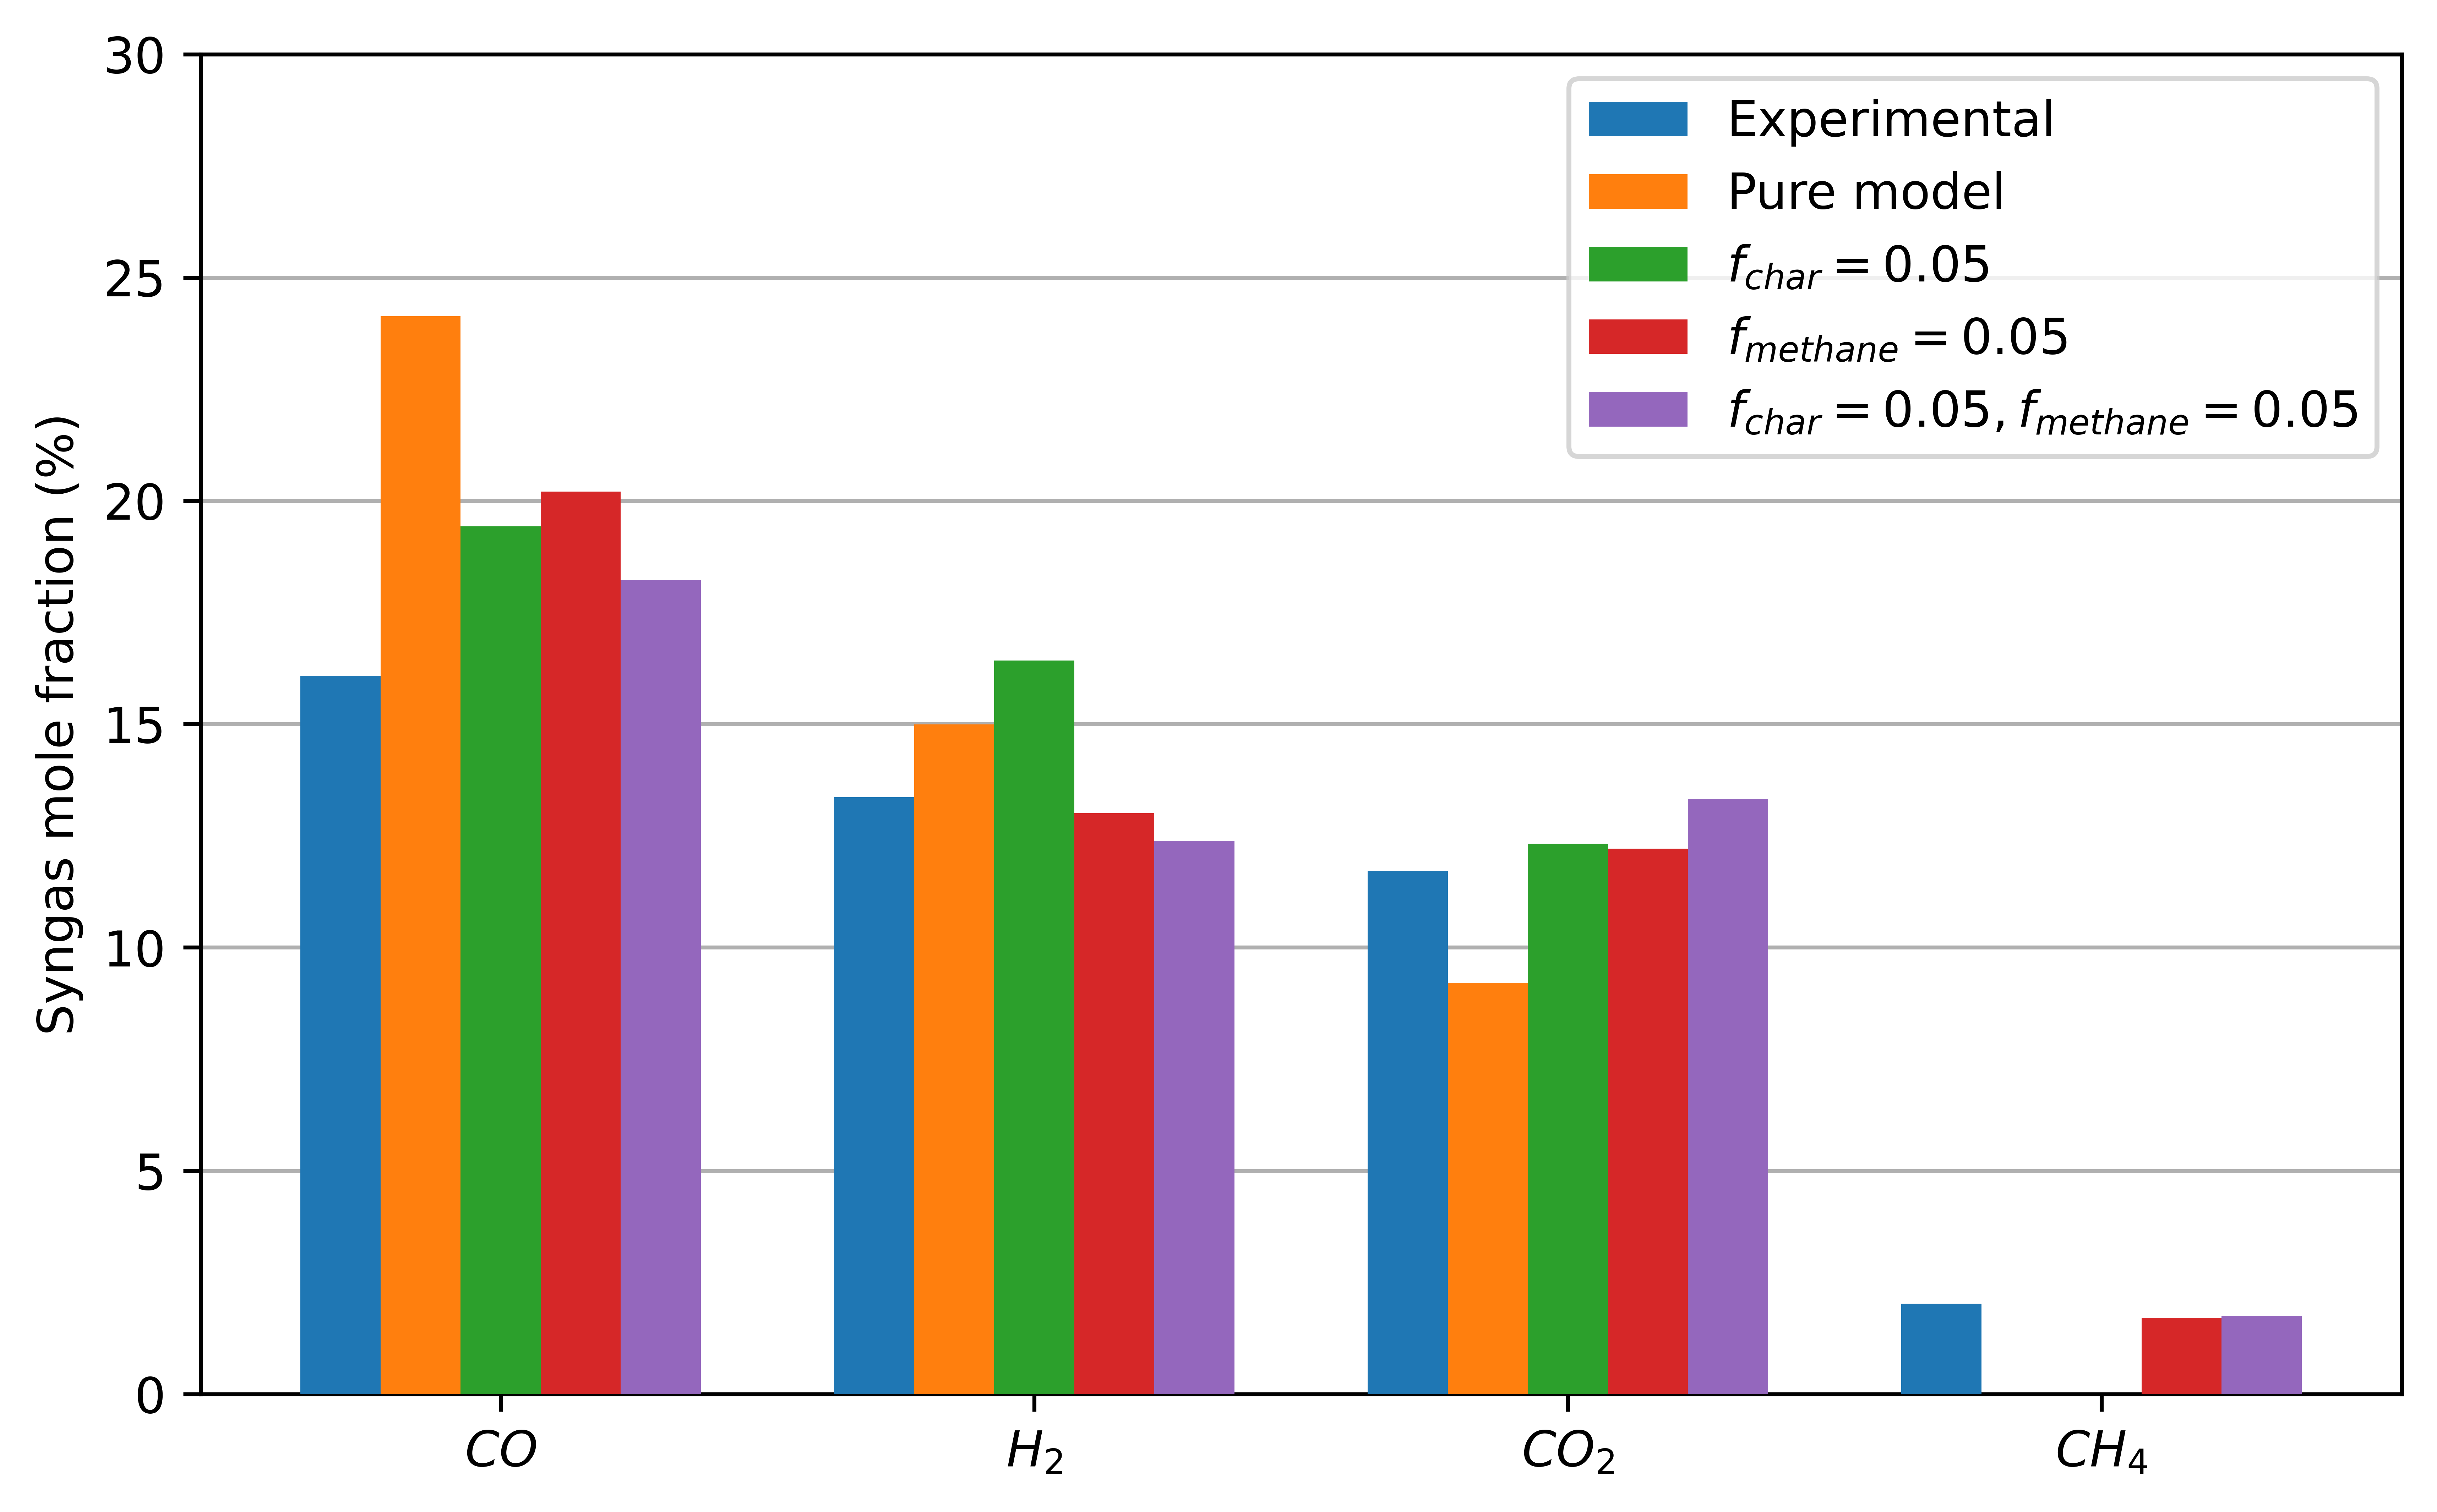

In [12]:
frac_groups = ['$CO$', '$H_2$', '$CO_2$', '$CH_4$']
exp_frac = [np.average(CO_exp), np.average(H2_exp), np.average(CO2_exp), np.average(CH4_exp)]
pure_model_frac = [np.average(CO), np.average(H2), np.average(CO2), np.average(CH4)]
char_model_frac = [np.average(CO_char), np.average(H2_char), np.average(CO2_char), np.average(CH4_char)]
met_model_frac = [np.average(CO_met), np.average(H2_met), np.average(CO2_met), np.average(CH4_met)]
both_model_frac = [np.average(CO_both), np.average(H2_both), np.average(CO2_both), np.average(CH4_both)]

X_axis1 = np.arange(len(frac_groups))

w = 0.15

fig = plt.figure(figsize=(8,5), dpi=1000)
plt.bar(X_axis1 - 2*w, exp_frac, w, label='Experimental', zorder=3)
plt.bar(X_axis1 - w, pure_model_frac, w, label='Pure model', zorder=3)
plt.bar(X_axis1, char_model_frac, w, label='$f_{char} = 0.05$', zorder=3)
plt.bar(X_axis1 + w, met_model_frac, w, label='$f_{methane} = 0.05$', zorder=3)
plt.bar(X_axis1 + 2*w, both_model_frac, w, label='$f_{char} = 0.05, f_{methane} = 0.05$', zorder=3)
plt.ylabel("Syngas mole fraction (%)")
plt.xticks(X_axis1, frac_groups)
plt.grid(zorder=0, axis='y')
plt.ylim(0, 30)

plt.legend(loc='best')
plt.savefig('figures/drogu1.jpg')
plt.show()

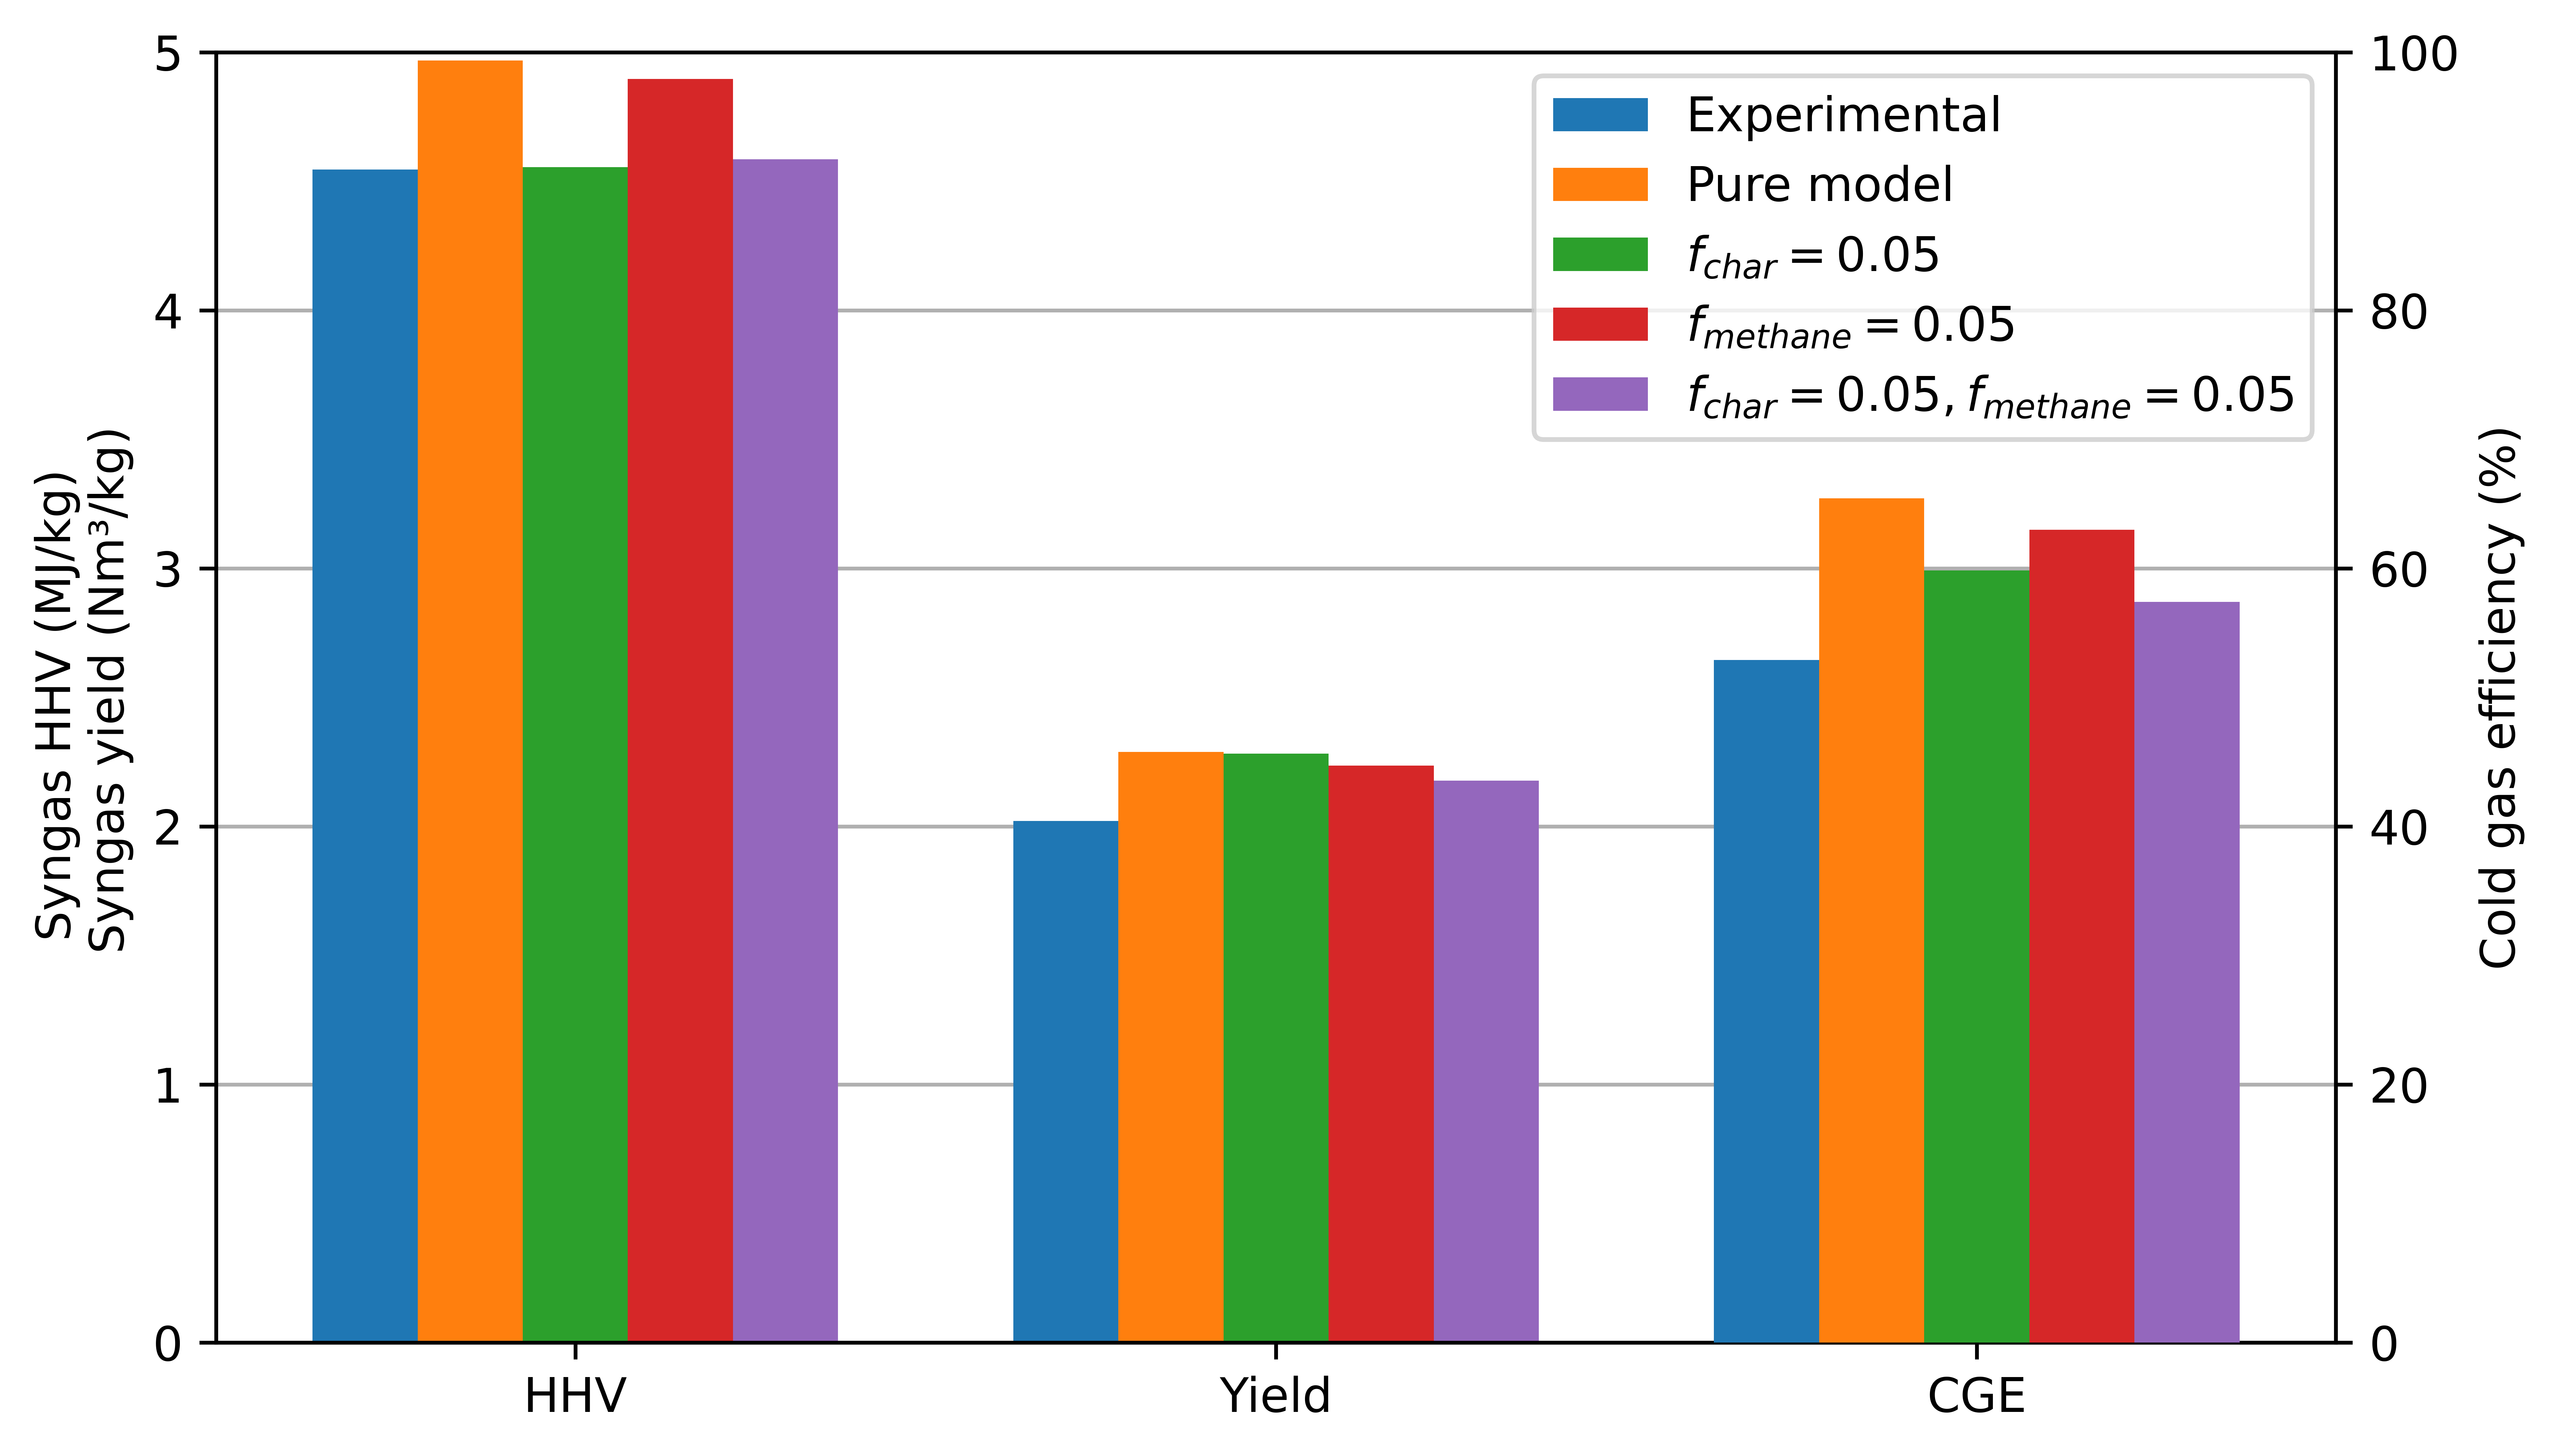

In [13]:
prop_groups = ['HHV', 'Yield', 'CGE']
exp_props = [np.average(HHV_exp), np.average(gasYield_exp), np.average(CGE_exp)]
pure_model_props = [np.average(syngasHHV), np.average(syngasYield), np.average(syngasCGE)]
char_model_props = [np.average(syngasHHV_char), np.average(syngasYield_char), np.average(syngasCGE_char)]
met_model_props = [np.average(syngasHHV_met), np.average(syngasYield_met), np.average(syngasCGE_met)]
both_model_props = [np.average(syngasHHV_both), np.average(syngasYield_both), np.average(syngasCGE_both)]

X_axis2 = np.arange(len(prop_groups))

w = 0.15

fig, ax1 = plt.subplots(figsize=(8,5), dpi=1000)
ax1.bar(X_axis2[:2] - 2*w, exp_props[:2], w, label='Experimental', zorder=3)
ax1.bar(X_axis2[:2] - w, pure_model_props[:2], w, label='Pure model', zorder=3)
ax1.bar(X_axis2[:2], char_model_props[:2], w, label='$f_{char} = 0.05$', zorder=3)
ax1.bar(X_axis2[:2] + w, met_model_props[:2], w, label='$f_{methane} = 0.05$', zorder=3)
ax1.bar(X_axis2[:2] + 2*w, both_model_props[:2], w, label='$f_{char} = 0.05, f_{methane} = 0.05$', zorder=3)
ax1.set_ylabel("Syngas HHV (MJ/kg) \n Syngas yield (Nm³/kg)")
ax1.set_xticks(X_axis2[:2], prop_groups[:2])
ax1.grid(zorder=0, axis='y')
ax1.set_ylim(0, 5)

ax2 = plt.twinx(ax1)
ax2.bar(X_axis2[2] - 2*w, 100*exp_props[2], w, label='Experimental', zorder=3)
ax2.bar(X_axis2[2] - w, 100*pure_model_props[2], w, label='Pure model', zorder=3)
ax2.bar(X_axis2[2], 100*char_model_props[2], w, label='$f_{char} = 0.05$', zorder=3)
ax2.bar(X_axis2[2] + w, 100*met_model_props[2], w, label='$f_{methane} = 0.05$', zorder=3)
ax2.bar(X_axis2[2] + 2*w, 100*both_model_props[2], w, label='$f_{char} = 0.05, f_{methane} = 0.05$', zorder=3)
ax2.set_ylabel("Cold gas efficiency (%)")
ax2.set_ylim(0, 100)

plt.xticks(X_axis2, prop_groups)

plt.legend(loc='best')
plt.savefig('figures/drogu2.jpg')
plt.show()